In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('used_cars.csv')

In [3]:
# esploro i dati
# Controllo le prime righe del dataset
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [4]:
# Verifico la struttura del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [5]:
# Controllo se ci sono valori mancanti
df.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [6]:
# Visualizzostatistiche descrittive per le colonne numeriche
print(df.describe())

        model_year
count  4009.000000
mean   2015.515590
std       6.104816
min    1974.000000
25%    2012.000000
50%    2017.000000
75%    2020.000000
max    2024.000000


In [7]:
# Visualizzo le features
df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [8]:
# Conteggio dei valori unici presenti in ogni colonna del DataFrame
df.nunique()

brand             57
model           1898
model_year        34
milage          2818
fuel_type          7
engine          1146
transmission      62
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

In [9]:
# Creo una copia del DataFrame
df_copy = df.copy()

# Rimuovo il simbolo del dollaro e le virgole nella colonna 'price' della copia
df_copy['price'] = df_copy['price'].replace({'\$': '', ',': ''}, regex=True)
# Verifico se ci sono valori non numerici e li converte in NaN
df_copy['price'] = pd.to_numeric(df_copy['price'], errors='coerce')

# Converto la colonna 'price' in numerico (int o float)
df_copy['price'] = pd.to_numeric(df_copy['price'])

# Rimuovo la virgola e la parte del testo 'mi.'
df_copy['milage'] = df_copy['milage'].replace({',': '', ' mi.': ''}, regex=True)
# Verifico se ci sono valori non numerici e li converte in NaN
df_copy['milage'] = pd.to_numeric(df_copy['milage'], errors='coerce')

# Converto la colonna in numerico 
df_copy['milage'] = pd.to_numeric(df_copy['milage'])

# Converto la colonna in int
df_copy['milage'] = df_copy['milage'].astype(int)

In [10]:
df_copy.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300
1,Hyundai,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,54598
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,34999


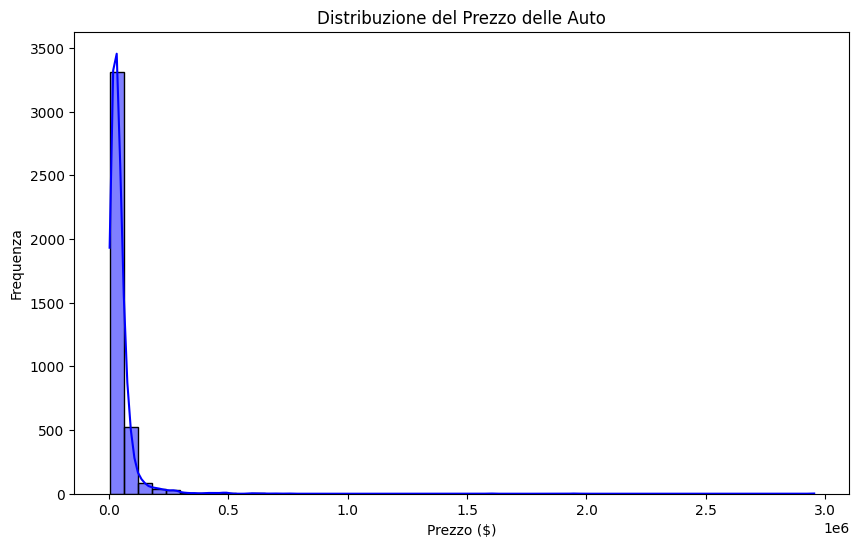

In [11]:
#faccio un grafico per visualizzare la distribuzione dei prezzi
# 1. Distribuzione del Prezzo
plt.figure(figsize=(10, 6))
sns.histplot(df_copy['price'], bins=50, kde=True, color='blue')
plt.title('Distribuzione del Prezzo delle Auto')
plt.xlabel('Prezzo ($)')
plt.ylabel('Frequenza')
plt.show()

Da questo grafico noto che ci sono tanti outliers quindi applico una trasformazione logaritmica per rendere la trasformazione più vicina a una trasformazioe normale

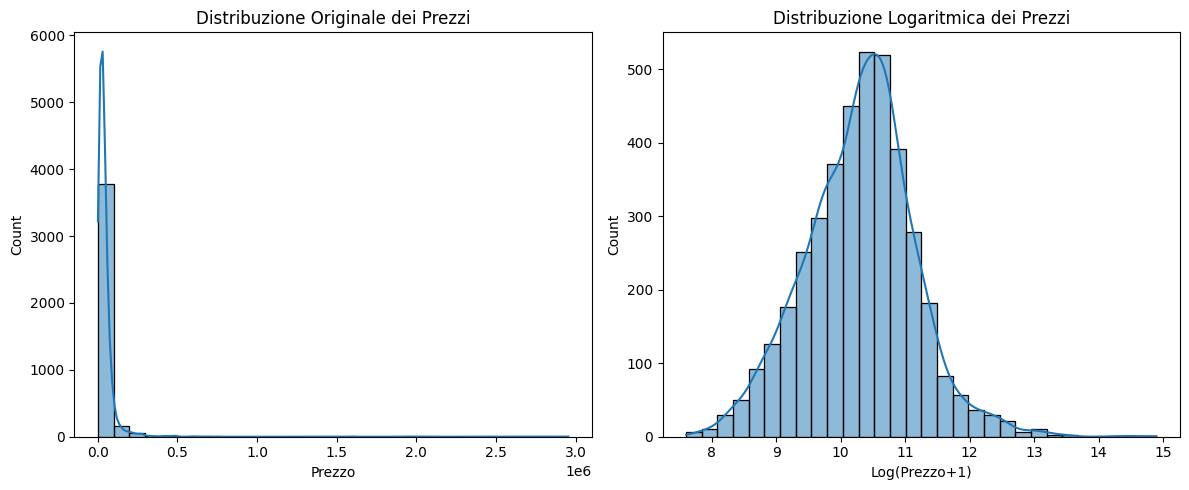

In [12]:
# A. Trasformazione logaritmica
df_copy['price_log'] = np.log1p(df_copy['price'])  # log(1+x) per gestire eventuali zeri

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_copy['price'], bins=30, kde=True)
plt.title('Distribuzione Originale dei Prezzi')
plt.xlabel('Prezzo')

plt.subplot(1, 2, 2)
sns.histplot(df_copy['price_log'], bins=30, kde=True)
plt.title('Distribuzione Logaritmica dei Prezzi')
plt.xlabel('Log(Prezzo+1)')

plt.tight_layout()
plt.show()

## ANALISI COLORI

C:\Users\franc\AppData\Local\Temp\ipykernel_18304\2253287147.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_extcol.index, y=top_10_extcol.values, palette='Set2')  # Usa 'top_10_extcol' per il grafico


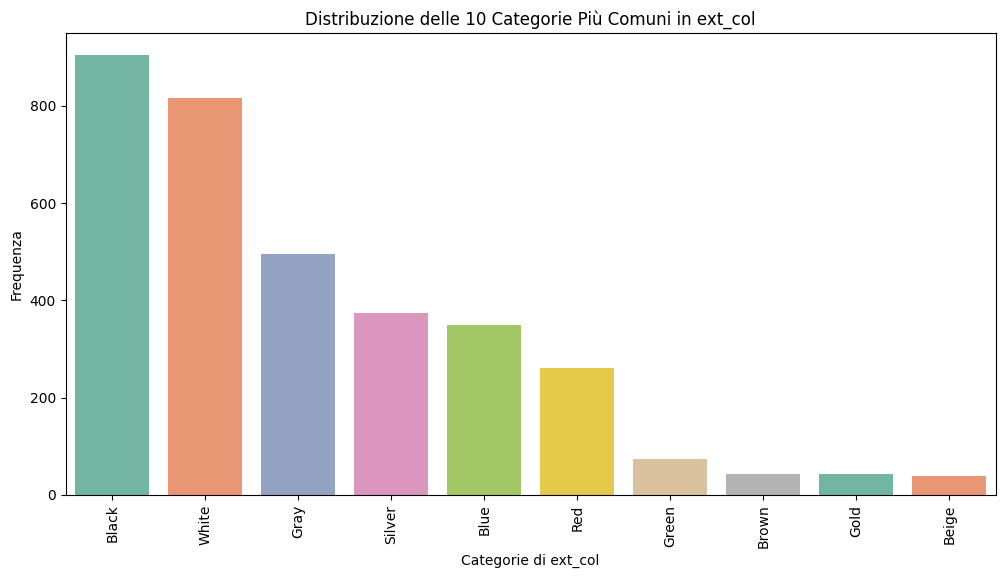

In [13]:
def filter_top_10(df, column):
    # Ottieni la frequenza delle categorie e seleziona le prime 10
    top_10 = df[column].value_counts().head(10)
    
    return top_10

# Applica il filtro per la colonna 'ext_col'
top_10_extcol = filter_top_10(df_copy, 'ext_col')

# Crea il grafico a barre
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_extcol.index, y=top_10_extcol.values, palette='Set2')  # Usa 'top_10_extcol' per il grafico
plt.title('Distribuzione delle 10 Categorie Più Comuni in ext_col')  
plt.xticks(rotation=90)
plt.xlabel('Categorie di ext_col')
plt.ylabel('Frequenza')
plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_18304\874025348.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='int_col', y='price_log', data=df_filtered_extcol, palette='Set2')


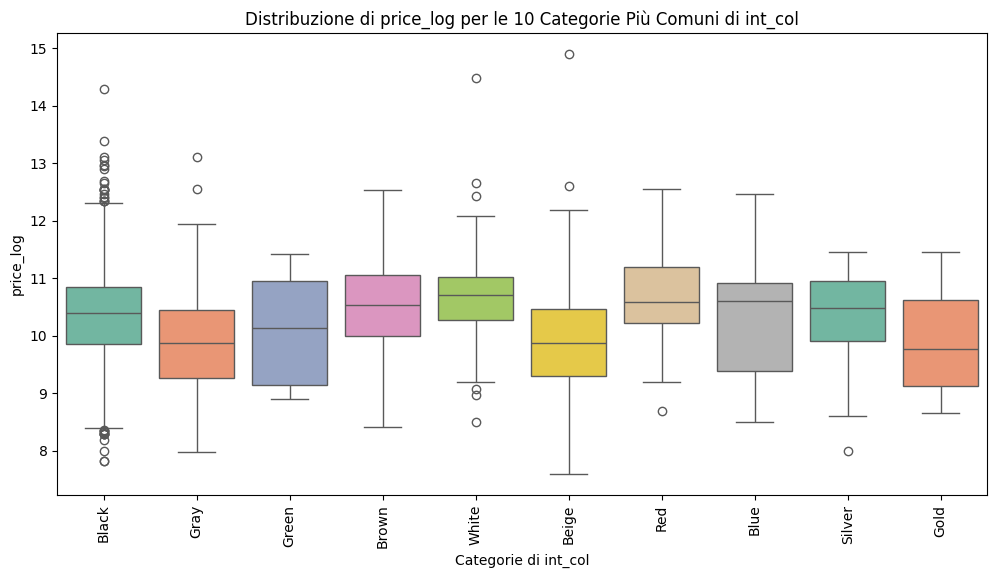

In [14]:
df_filtered_extcol = df_copy[df_copy['int_col'].isin(top_10_extcol.index)]

# 4. Crea il boxplot per visualizzare la distribuzione di 'price_log' per ciascuna delle 10 categorie di 'int_col'
plt.figure(figsize=(12, 6))
sns.boxplot(x='int_col', y='price_log', data=df_filtered_extcol, palette='Set2')
plt.title('Distribuzione di price_log per le 10 Categorie Più Comuni di int_col')
plt.xticks(rotation=90)
plt.xlabel('Categorie di int_col')
plt.ylabel('price_log')
plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_18304\530787065.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_intcol.index, y=top_10_intcol.values, palette='Set2')


Text(0, 0.5, 'Frequenza')

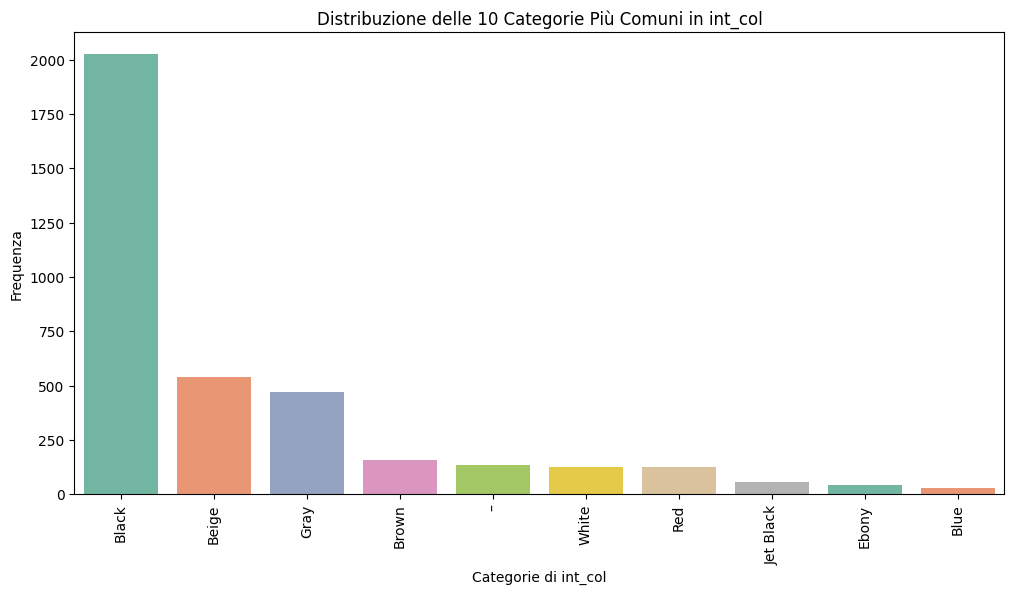

In [15]:
# 1. Trova le prime 10 categorie più comuni di 'int_col'
top_10_intcol = filter_top_10(df_copy, 'int_col')

# 2. Crea il grafico a barre per le 10 categorie più comuni di 'int_col'
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_intcol.index, y=top_10_intcol.values, palette='Set2')
plt.title('Distribuzione delle 10 Categorie Più Comuni in int_col')
plt.xticks(rotation=90)
plt.xlabel('Categorie di int_col')
plt.ylabel('Frequenza')

C:\Users\franc\AppData\Local\Temp\ipykernel_18304\2996170280.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='int_col', y='price_log', data=df_filtered_intcol, palette='Set2')


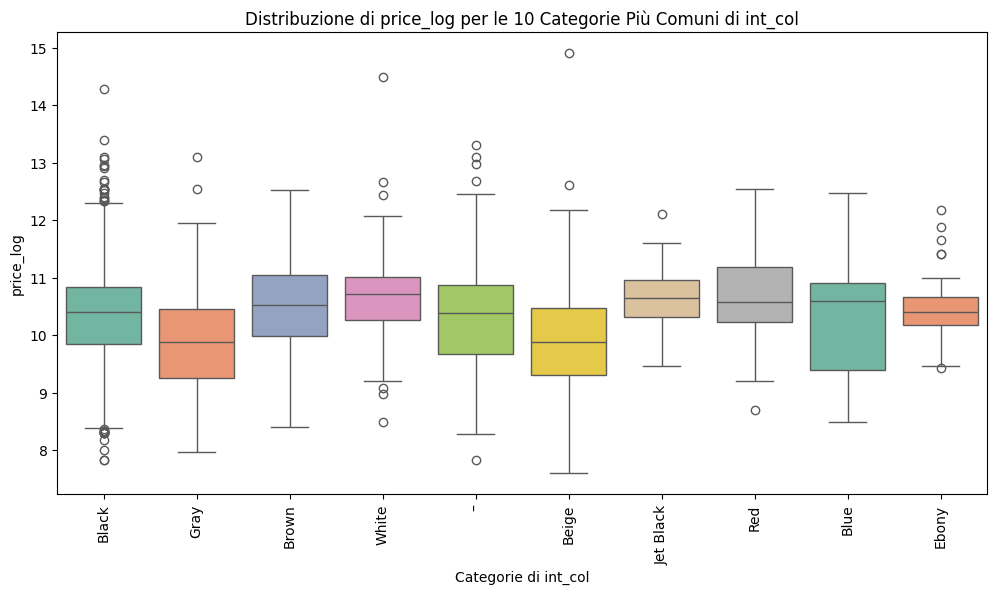

In [16]:
df_filtered_intcol = df_copy[df_copy['int_col'].isin(top_10_intcol.index)]

# 4. Crea il boxplot per visualizzare la distribuzione di 'price_log' per ciascuna delle 10 categorie di 'int_col'
plt.figure(figsize=(12, 6))
sns.boxplot(x='int_col', y='price_log', data=df_filtered_intcol, palette='Set2')
plt.title('Distribuzione di price_log per le 10 Categorie Più Comuni di int_col')
plt.xticks(rotation=90)
plt.xlabel('Categorie di int_col')
plt.ylabel('price_log')
plt.show()

## ANALISI BRAND

C:\Users\franc\AppData\Local\Temp\ipykernel_18304\780907975.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_model.index, y=top_10_model.values, palette='Set2')


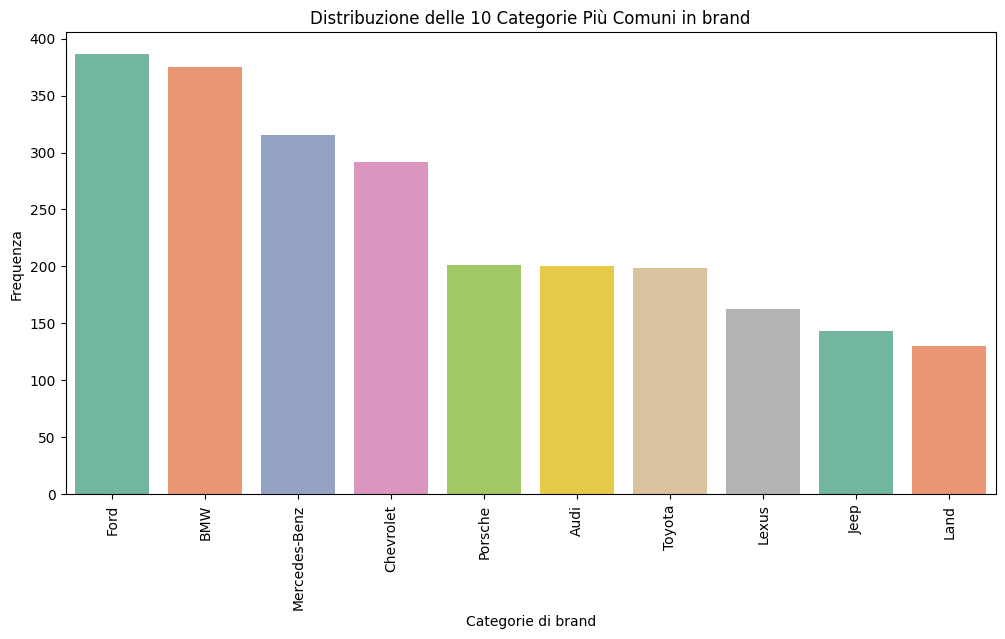

In [17]:
top_10_model = filter_top_10(df_copy, 'brand')

# 2. Crea il grafico a barre per le 10 categorie più comuni di 'model'
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_model.index, y=top_10_model.values, palette='Set2')
plt.title('Distribuzione delle 10 Categorie Più Comuni in brand')
plt.xticks(rotation=90)
plt.xlabel('Categorie di brand')
plt.ylabel('Frequenza')
plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_18304\191001080.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='brand', y='price_log', data=df_filtered_brand, palette='Set2')


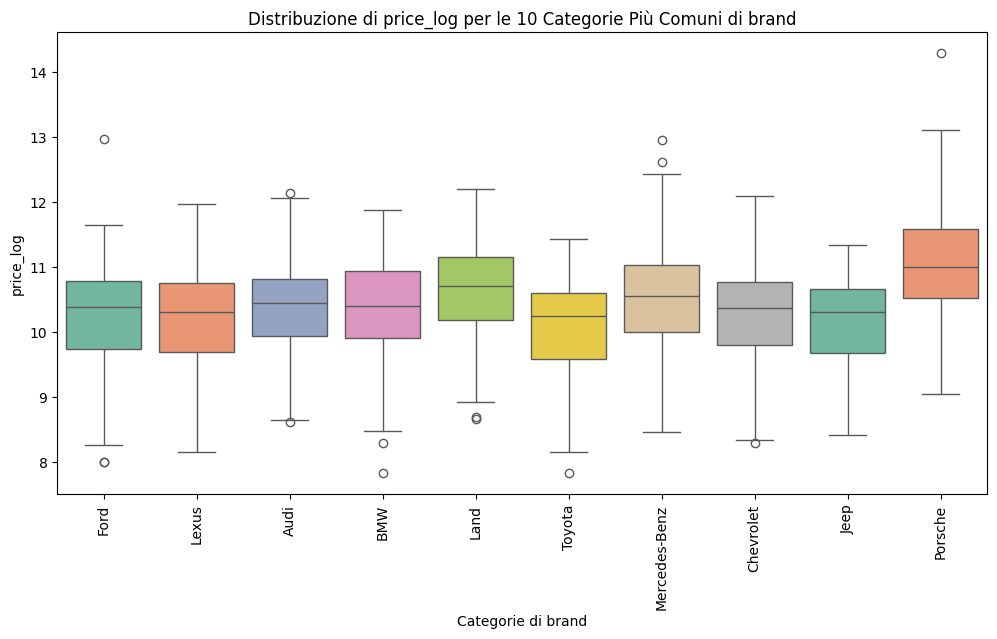

In [18]:
df_filtered_brand = df_copy[df_copy['brand'].isin(top_10_model.index)]

# 4. Crea il boxplot per visualizzare la distribuzione di 'price_log' per ciascuna delle 10 categorie di 'model'
plt.figure(figsize=(12, 6))
sns.boxplot(x='brand', y='price_log', data=df_filtered_brand, palette='Set2')
plt.title('Distribuzione di price_log per le 10 Categorie Più Comuni di brand')
plt.xticks(rotation=90)
plt.xlabel('Categorie di brand')
plt.ylabel('price_log')
plt.show()

## CONTROLLO DI PREZZI OUTLIER

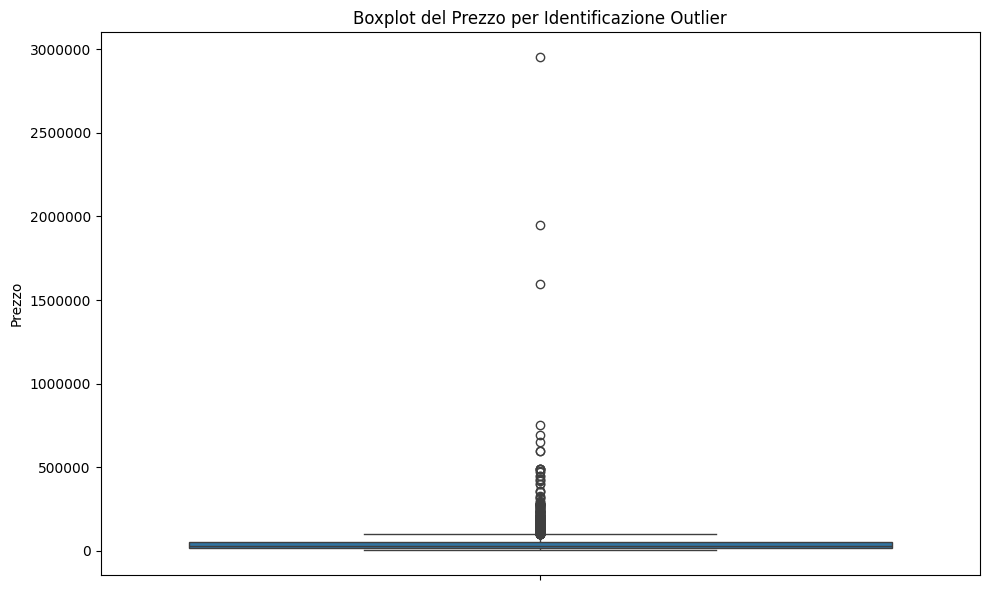

In [19]:
# Verifica degli outlier con boxplot per il prezzo
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_copy['price'])
plt.title('Boxplot del Prezzo per Identificazione Outlier')
plt.ylabel('Prezzo')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

In [20]:
#cerco degli outliers
df_copy = df_copy.dropna(subset=['price'])

# Calcolare Q1 (25° percentile) e Q3 (75° percentile) per la colonna 'price'
Q1 = df_copy['price'].quantile(0.25)
Q3 = df_copy['price'].quantile(0.75)

# Calcolare l'IQR
IQR = Q3 - Q1

# Definire i limiti inferiore e superiore per gli outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificare gli outlier (valori fuori dal range definito)
outliers = df_copy[(df_copy['price'] < lower_bound) | (df_copy['price'] > upper_bound)]
print(f"\nNumero di outlier usando il metodo IQR: {len(outliers)}")
print(f"Limite superiore IQR: {upper_bound}")


Numero di outlier usando il metodo IQR: 244
Limite superiore IQR: 99175.0


In [21]:
#controllo se ci sono ancora outlier dopo la trasformazione logaritmica
# Calcolare Q1 (25° percentile) e Q3 (75° percentile) per la colonna 'price'
Q1 = df_copy['price_log'].quantile(0.25)
Q3 = df_copy['price_log'].quantile(0.75)

# Calcolare l'IQR
IQR = Q3 - Q1

# Definire i limiti inferiore e superiore per gli outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificare gli outlier (valori fuori dal range definito)
outliers = df_copy[(df_copy['price_log'] < lower_bound) | (df_copy['price_log'] > upper_bound)]
print(f"\nNumero di outlier usando il metodo IQR: {len(outliers)}")
print(f"Limite superiore IQR: {upper_bound}")


Numero di outlier usando il metodo IQR: 66
Limite superiore IQR: 12.41991146955126


## MATRICE DI CORRELAZIONE DELLE VARIABILI NUMERICHE

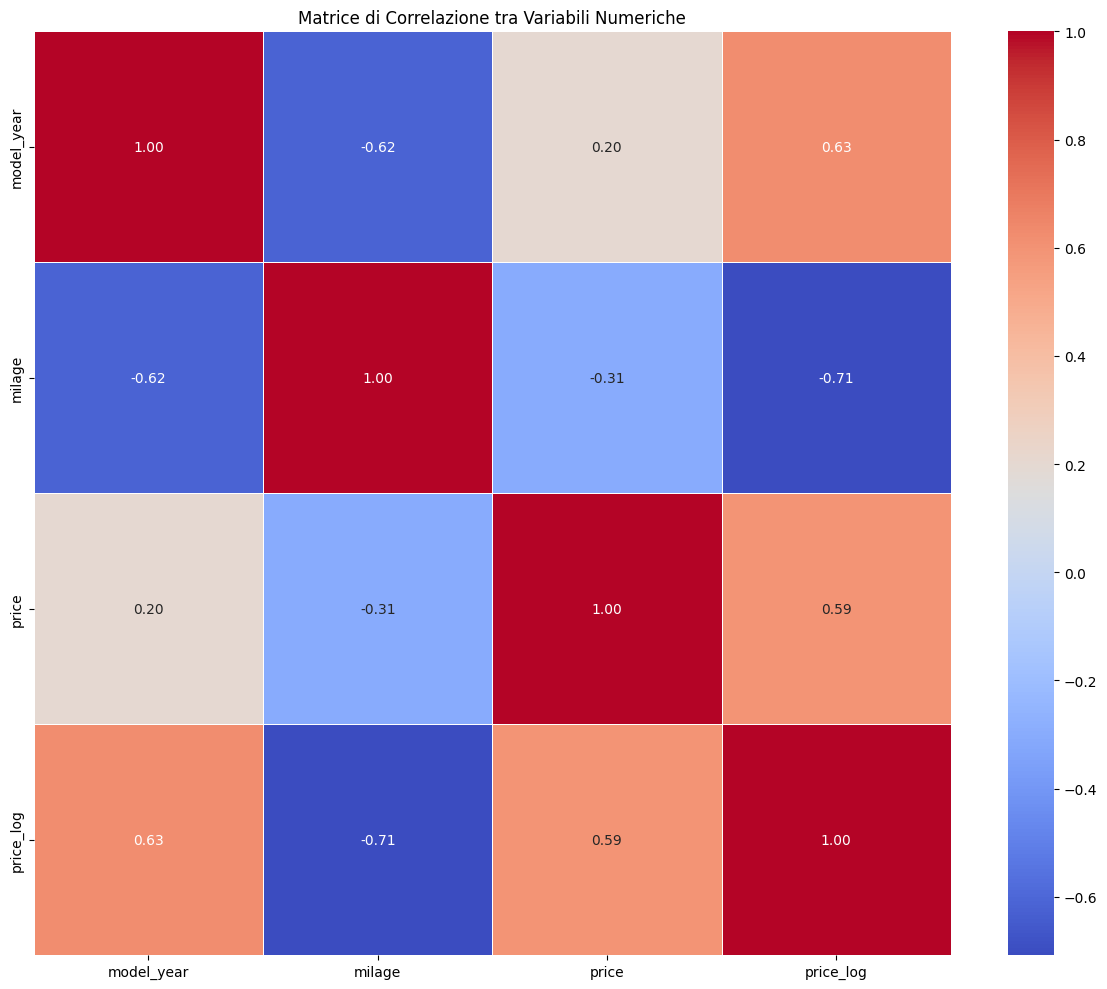

In [22]:
numeric = df_copy.select_dtypes(include=[np.number])
correlation_log = numeric.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_log, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice di Correlazione tra Variabili Numeriche')
plt.tight_layout()
plt.show()

- correlazione importante tra model_year e price_log (auto più recenti hanno prezzi più alti)
- correlazione negativa importante tra milage e price_log (auto con più chilometri hanno prezzi più bassi)

## Prima di applciare trasformazioni nei dati applico un modello naive ai dati non modificati

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assumiamo che tu abbia già il dataframe df_copy e una variabile target (ad esempio, 'price_log' o 'price')

# Separa i dati in feature (X) e target (y)
X = df_copy.drop(columns=['price', 'price_log'])  # Seleziona le feature (senza la colonna 'price' o 'price_log')
y = df_copy['price']  # O 'price_log' se preferisci

# Divisione in training e test (80% allenamento, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creazione della previsione naive basata sulla media dei prezzi
mean_price = df_copy['price'].mean()

# La previsione naive è semplicemente la media del prezzo per tutte le osservazioni
y_pred_naive = np.full_like(y_test, mean_price, dtype=float)

# Funzione di valutazione del modello
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}')
    return mae, rmse, r2

# Valutazione del modello naive
print("Risultati modello naive (media del prezzo):")
mae_naive, rmse_naive, r2_naive = evaluate_model("Modello Naive (Media)", y_test, y_pred_naive)



Risultati modello naive (media del prezzo):
Modello Naive (Media): MAE=35834.29, RMSE=143080.93, R²=-0.0016


## Identificazione delle colonne per tipo (num, cat)

In [24]:
numeric_cols = df_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_copy.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

print(f"Colonne numeriche: {numeric_cols}")
print(f"Colonne categoriche: {categorical_cols}")

Colonne numeriche: ['model_year', 'milage', 'price', 'price_log']
Colonne categoriche: ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


## feature engineering

In [25]:
df_copy.fillna({
    'price': df_copy['price'].median(),
    'fuel_type': df_copy['fuel_type'].mode()[0],
    'accident': 'None reported',
    'clean_title': 'Yes'
}, inplace=True)

# Creare la colonna 'mileage_per_year'
df_copy['mileage_per_year'] = df_copy['milage'] / (2025 - df_copy['model_year'])
# creo la colonna 'price_per_mile'
df_copy['price_per_mile'] = df_copy['price'] / df_copy['milage'].replace(0, np.nan)  # Evita divisione per zero


## applicazione modelli

In [26]:
# Seleziona le feature (senza 'price', 'price_log', 'milage')
X = df_filtered_extcol.drop(columns=['price', 'price_log', 'milage'])
y = df_filtered_extcol['price_log']  # O 'price' se preferisci

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing per numeriche e categoriche
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Escludiamo 'price_log' dalla lista delle feature numeriche da scalare
numeric_features = [col for col in numeric_features if col != 'price_log']

# Creazione del ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Applicare StandardScaler alle variabili numeriche
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Applicare OneHotEncoder alle variabili categoriche
    ])

# Creazione delle pipeline per i modelli
rf_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

xgb_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=100, random_state=42))
])

lasso_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=0.1, random_state=42))  # Lasso con una regolarizzazione moderata
])

gb_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

# Funzione per valutare i modelli
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}')
    return mae, rmse, r2

# Addestramento e valutazione dei modelli
print("Risultati Random Forest:")
rf_model_pipeline.fit(X_train, y_train)
y_pred_rf = rf_model_pipeline.predict(X_test)
mae_rf, rmse_rf, r2_rf = evaluate_model("Random Forest", y_test, y_pred_rf)

print("Risultati XGBoost:")
xgb_model_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_model_pipeline.predict(X_test)
mae_xgb, rmse_xgb, r2_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb)

print("Risultati Lasso:")
lasso_model_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_model_pipeline.predict(X_test)
mae_lasso, rmse_lasso, r2_lasso = evaluate_model("Lasso", y_test, y_pred_lasso)

print("Risultati Gradient Boosting:")
gb_model_pipeline.fit(X_train, y_train)
y_pred_gb = gb_model_pipeline.predict(X_test)
mae_gb, rmse_gb, r2_gb = evaluate_model("Gradient Boosting", y_test, y_pred_gb)


Risultati Random Forest:
Random Forest: MAE=0.31, RMSE=0.43, R²=0.7119
Risultati XGBoost:
XGBoost: MAE=0.30, RMSE=0.41, R²=0.7391
Risultati Lasso:
Lasso: MAE=0.46, RMSE=0.62, R²=0.4129
Risultati Gradient Boosting:
Gradient Boosting: MAE=0.35, RMSE=0.46, R²=0.6692


Nel complesso, XGBoost sembra il miglior modello in termini di precisione, seguito da Random Forest, mentre Lasso appare come il meno efficace.